In [13]:
import pandas as pd
import gurobipy as gp
import numpy as np
from gurobipy import Model, GRB
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import math
from collections import OrderedDict
import gurobipy as gp
from gurobipy import Model, GRB, LinExpr

In [25]:
#Load data
SKU_data = pd.read_excel("LL data.xlsx", sheet_name="Data Sheet", header=None)

In [27]:
SKU_data

,0,1,2,3,4,5,6,7
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,Profit margin per SKU (in %),NaN,NaN,NaN,NaN,NaN,NaN
3,1.0,Profit margin,Profit Margin %,NaN,NaN,NaN,NaN,NaN
4,NaN,Shawl,0.25,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
58,NaN,Scarf,NaN,10,NaN,NaN,NaN,NaN
59,NaN,Sweater,NaN,2,NaN,NaN,NaN,NaN
60,NaN,Muffler,NaN,4,NaN,NaN,NaN,NaN
61,NaN,Cap,NaN,5,NaN,NaN,NaN,NaN


In [17]:
# ============================================================
# Looms of Ladakh — Shawls or Stoles (15-day rush)
# Gurobi model + plots + price–demand fit (no shadow prices)
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---- Gurobi imports exactly as requested ----
import gurobipy as gp
from gurobipy import Model, GRB

# -----------------------------
# PARAMETERS (case-based)
# -----------------------------
products = ["Shawl","Stole","Scarf","Sweater","Muffler","Cap","Gloves"]
ptype    = {"Shawl":"Woven","Stole":"Woven","Scarf":"Woven",
            "Sweater":"Knit","Muffler":"Knit","Cap":"Knit","Gloves":"Knit"}

# Grams per unit (Exhibit 4)
g = {"Shawl":510, "Stole":390, "Scarf":210, "Sweater":320, "Muffler":175, "Cap":75, "Gloves":73}

# Per-gram costs (₹) (Exhibit 4) + finishing for all
raw_cost_per_g   = 10.25
finishing_per_g  = 0.60
weaving_per_g    = {"Shawl":1.46, "Stole":1.79, "Scarf":3.00}
knitting_per_g   = {"Sweater":3.00, "Muffler":3.00, "Cap":3.00, "Gloves":3.00}

# Dye (₹ per unit) (Exhibit 4)
dye = {"Shawl":830, "Stole":635, "Scarf":342, "Sweater":488, "Muffler":285, "Cap":122, "Gloves":119}

# Resources / horizon (Exhibits 4–5)
DAYS = 15
weavers  = 5
knitters = 13
rate = {"Weaving":500, "Knitting":50}   # grams/person/day

# Yarn availability (grams) (Exhibit 5)
woven_raw_g = 15_000
knit_raw_g  = 23_000

# Minimum SKUs (Exhibit 6)
min_sku = {"Shawl":2, "Stole":5, "Scarf":10, "Sweater":2, "Muffler":4, "Cap":5, "Gloves":5}

# -----------------------------
# ECONOMICS — unit gross contribution (₹)
# Price = 2 × base manufacturing cost  ⇒ contribution = base cost = raw+finish+activity+dye
# -----------------------------
def unit_cost(p):
    base = g[p]*(raw_cost_per_g + finishing_per_g)
    base += (g[p]*weaving_per_g[p] if ptype[p]=="Woven" else g[p]*knitting_per_g[p])
    base += dye[p]
    return base

unit_profit = {p: unit_cost(p) for p in products}

# -----------------------------
# MODEL BUILD
# -----------------------------
def build_and_solve(
    W=weavers, K=knitters, WR=woven_raw_g, KR=knit_raw_g,
    weave_rate=rate["Weaving"], knit_rate=rate["Knitting"],
    vtype=GRB.INTEGER, verbose=False
):
    m: Model = gp.Model("LL_15Day")
    m.Params.OutputFlag = 1 if verbose else 0

    # decision variables
    x = m.addVars(products, name="x", vtype=vtype, lb=0)

    # objective
    m.setObjective(gp.quicksum(unit_profit[p]*x[p] for p in products), GRB.MAXIMIZE)

    # capacities
    weave_cap = W * DAYS * weave_rate
    knit_cap  = K * DAYS * knit_rate

    total_woven_g = gp.quicksum(g[p]*x[p] for p in products if ptype[p]=="Woven")
    total_knit_g  = gp.quicksum(g[p]*x[p] for p in products if ptype[p]=="Knit")

    # enforce BOTH time and raw caps (no min(...) with variables)
    m.addConstr(total_woven_g <= weave_cap, name="Weave_Time")
    m.addConstr(total_woven_g <= WR,        name="Weave_Raw")

    m.addConstr(total_knit_g  <= knit_cap,  name="Knit_Time")
    m.addConstr(total_knit_g  <= KR,        name="Knit_Raw")

    # Okhai minima
    for p, v in min_sku.items():
        m.addConstr(x[p] >= v, name=f"MinSKU_{p}")

    m.optimize()

    sol = {p: (int(round(x[p].X)) if x[p].X is not None else 0) for p in products}
    used_woven = sum(g[p]*sol[p] for p in products if ptype[p]=="Woven")
    used_knit  = sum(g[p]*sol[p] for p in products if ptype[p]=="Knit")
    caps = {"weave_cap": weave_cap, "knit_cap": knit_cap, "used_woven": used_woven, "used_knit": used_knit,
            "WR": WR, "KR": KR}
    return m, sol, float(m.ObjVal), caps

# ------ Solve base model ------
mip, sol, obj, caps = build_and_solve()

print("Status code:", mip.Status, "(2=OPTIMAL)")
print("\nOptimal plan (units):")
for p in products:
    print(f"  {p:8s}: {sol[p]}")
print("\nCapacity check (grams):")
print(f"  WOVEN used {caps['used_woven']:,} / time cap {caps['weave_cap']:,} / yarn cap {caps['WR']:,}")
print(f"  KNIT  used {caps['used_knit']:,} / time cap {caps['knit_cap']:,} / yarn cap {caps['KR']:,}")
print("\nObjective value (₹):", round(obj, 2))


Status code: 2 (2=OPTIMAL)

Optimal plan (units):
  Shawl   : 2
  Stole   : 5
  Scarf   : 57
  Sweater : 2
  Muffler : 4
  Cap     : 7
  Gloves  : 108

Capacity check (grams):
  WOVEN used 14,940 / time cap 37,500 / yarn cap 15,000
  KNIT  used 9,749 / time cap 9,750 / yarn cap 23,000

Objective value (₹): 378163.35


In [15]:
# SCENARIOS (simple what-ifs)
# -----------------------------
def scenario(label, **kwargs):
    _m, s, o, c = build_and_solve(**kwargs)
    return {
        "Scenario": label,
        "Profit": round(o, 2),
        **{f"x_{p}": s[p] for p in products},
        "WovenUsed_g": c["used_woven"], "WovenTimeCap_g": c["weave_cap"], "WovenYarnCap_g": c["WR"],
        "KnitUsed_g":  c["used_knit"],  "KnitTimeCap_g":  c["knit_cap"],  "KnitYarnCap_g":  c["KR"],
    }

scenarios = []
# vary knitters & rates & yarn a bit
for d in (-3, 0, +3):
    scenarios.append(scenario(f"Knitters {knitters+d}", K=knitters+d))
for frac in (0.9, 1.1):
    scenarios.append(scenario(f"KnitRate {int(frac*100)}%", knit_rate=int(rate["Knitting"]*frac)))
for frac in (0.9, 1.1):
    scenarios.append(scenario(f"WovenYarn {int(frac*100)}%", WR=int(woven_raw_g*frac)))
    scenarios.append(scenario(f"KnitYarn {int(frac*100)}%",  KR=int(knit_raw_g*frac)))

scen_df = pd.DataFrame(scenarios)
print("\nScenario summary (first rows):")
print(scen_df.head())


Scenario summary (first rows):
        Scenario     Profit  x_Shawl  x_Stole  x_Scarf  x_Sweater  x_Muffler  \
0    Knitters 10  343316.00        2        5       57          2          4   
1    Knitters 13  378163.35        2        5       57          2          4   
2    Knitters 16  412998.70        2        5       57          2         44   
3   KnitRate 90%  363079.45        2        5       57          2          4   
4  KnitRate 110%  393241.25        2        5       57          2          5   

   x_Cap  x_Gloves  WovenUsed_g  WovenTimeCap_g  WovenYarnCap_g  KnitUsed_g  \
0     13        71        14940           37500           15000        7498   
1      7       108        14940           37500           15000        9749   
2      5        45        14940           37500           15000       12000   
3     31        70        14940           37500           15000        8775   
4      5       121        14940           37500           15000       10723   

   KnitTimeC

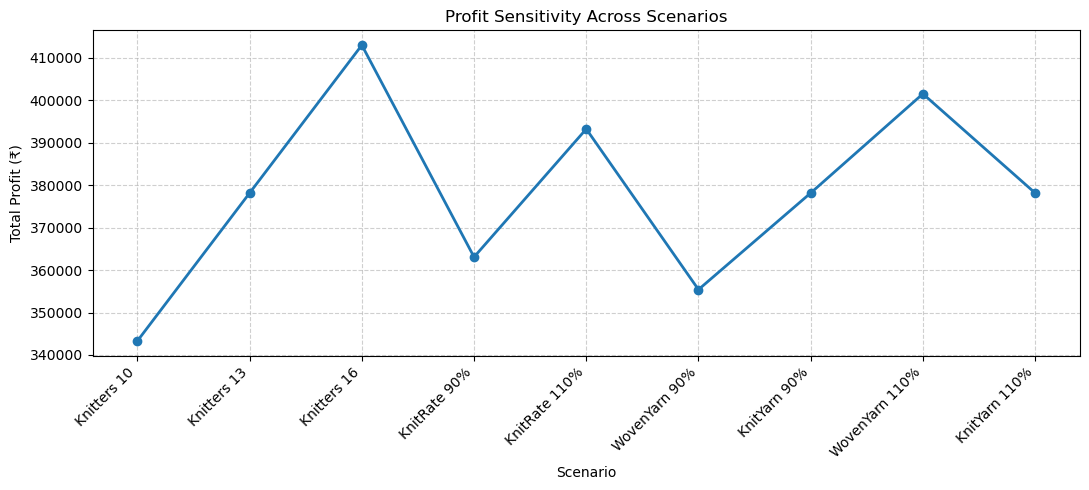

In [19]:
# Profit sensitivity across scenarios
plt.figure(figsize=(11,5))
plt.plot(scen_df['Scenario'], scen_df['Profit'], marker='o', linewidth=2)
plt.xticks(rotation=45, ha='right')
plt.xlabel("Scenario")
plt.ylabel("Total Profit (₹)")
plt.title("Profit Sensitivity Across Scenarios")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


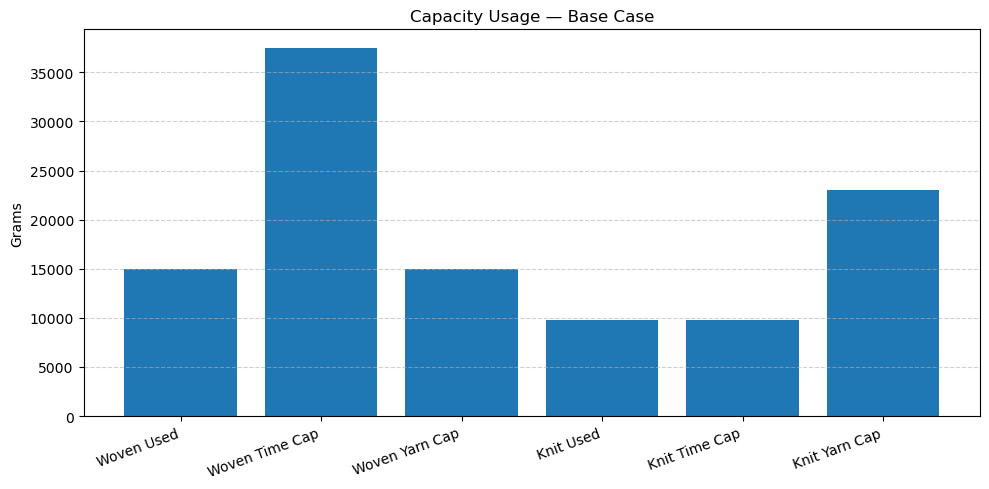

In [9]:
# Base-case capacity usage
cap_labels = ["Woven Used", "Woven Time Cap", "Woven Yarn Cap",
              "Knit Used",  "Knit Time Cap",  "Knit Yarn Cap"]
cap_vals   = [caps['used_woven'], caps['weave_cap'], caps['WR'],
              caps['used_knit'],  caps['knit_cap'],  caps['KR']]

plt.figure(figsize=(10,5))
plt.bar(cap_labels, cap_vals)
plt.xticks(rotation=20, ha='right')
plt.ylabel("Grams")
plt.title("Capacity Usage — Base Case")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# ============================================================
# PRICE–DEMAND FIT & PLOT
# ============================================================

# Example historical price-demand data (replace with your real data)
prices = np.array([250, 275, 300, 325, 350, 375, 400], dtype=float)
demand = np.array([180, 160, 140, 120, 105,  95,  80], dtype=float)

# Fit linear demand: Demand = a + b*Price  (use numpy.polyfit for minimal deps)
b, a = np.polyfit(prices, demand, 1)  # returns slope, intercept
# So fitted: demand_hat = a + b * price

# Generate fitted demand values
price_range   = np.linspace(prices.min(), prices.max(), 100)  # Smooth range of prices
fitted_demand = a + b * price_range                           # Compute fitted demand


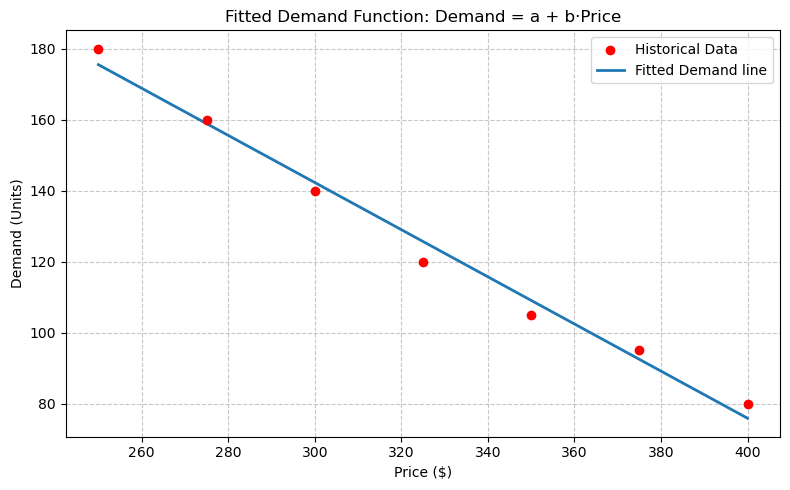


Fitted demand function: Demand = 341.61 + (-0.664)*Price


In [5]:

# Plot original data and fitted curve
plt.figure(figsize=(8,5))
plt.scatter(prices, demand, color='red', label="Historical Data", zorder=3)   # Scatter plot of actual data
plt.plot(price_range, fitted_demand, label="Fitted Demand line", linewidth=2) # Fitted curve
plt.xlabel("Price ($)")
plt.ylabel("Demand (Units)")
plt.title("Fitted Demand Function: Demand = a + b·Price")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print(f"\nFitted demand function: Demand = {a:.2f} + ({b:.3f})*Price")